yt has capabilities for writing 2D and 3D uniformly gridded data generated from datasets to FITS files. This is via the `FITSImageData` class. We'll test these capabilities out on an Athena dataset.

In [1]:
import yt

In [2]:
units_override = {
    "length_unit": (1.0, "Mpc"),
    "mass_unit": (1.0e14, "Msun"),
    "time_unit": (1.0, "Myr"),
}
ds = yt.load("MHDSloshing/virgo_low_res.0054.vtk", units_override=units_override)

## Creating FITS images from Slices and Projections

There are several ways to make a `FITSImageData` instance. The most intuitive ways are to use the `FITSSlice`, `FITSProjection`, `FITSOffAxisSlice`, and `FITSOffAxisProjection` classes to write slices and projections directly to FITS. To demonstrate a useful example of creating a FITS file, let's first make a `ProjectionPlot`:


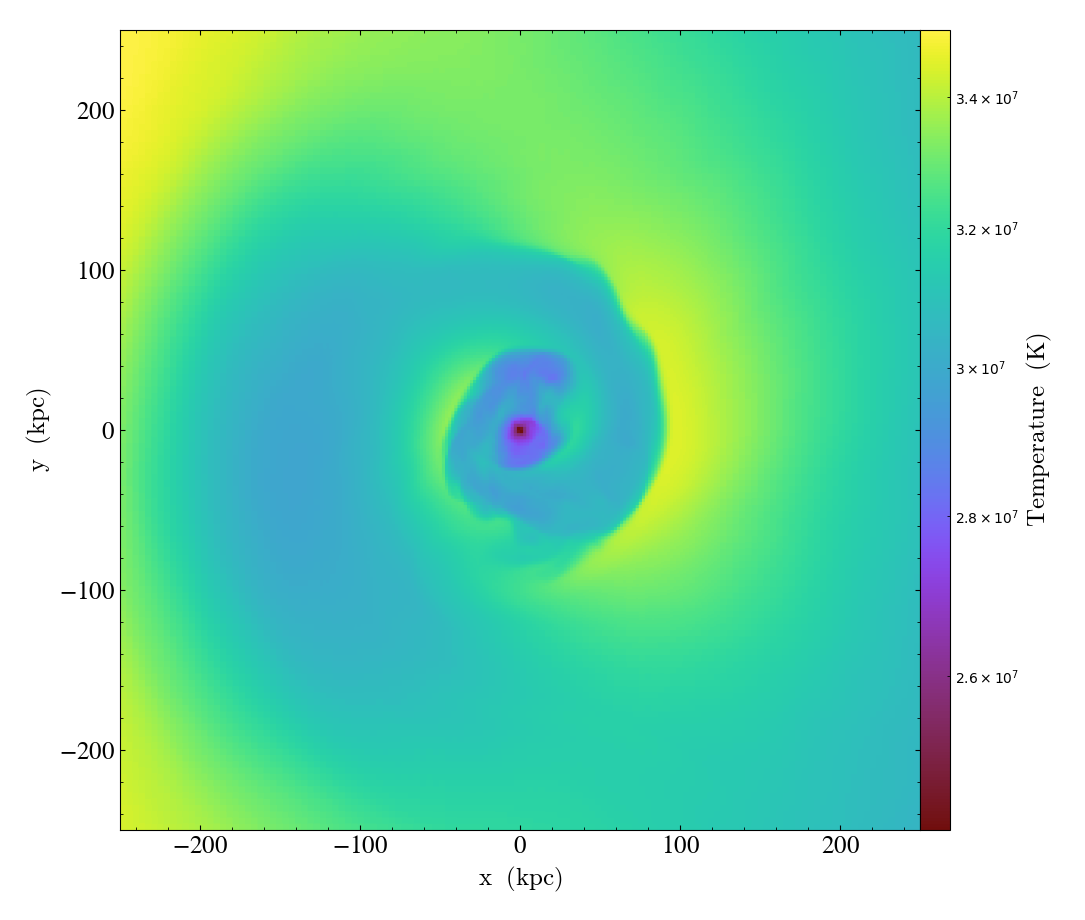

In [3]:
prj = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "temperature"),
    weight_field=("gas", "density"),
    width=(500.0, "kpc"),
)
prj.show()

Suppose that we wanted to write this projection to a FITS file for analysis and visualization in other programs, such as ds9. We can do that using `FITSProjection`:

In [4]:
prj_fits = yt.FITSProjection(
    ds, "z", ("gas", "temperature"), weight_field=("gas", "density")
)

which took the same parameters as `ProjectionPlot` except the width, because `FITSProjection` and `FITSSlice` always make slices and projections of the width of the domain size, at the finest resolution available in the simulation, in a unit determined to be appropriate for the physical size of the dataset.

We can also set width manually in `FITSProjection`. For example, set the width to 500 kiloparsec to get FITS file of the same projection plot as discussed above.

In [5]:
prj_fits = yt.FITSProjection(
    ds,
    "z",
    ("gas", "temperature"),
    weight_field=("gas", "density"),
    width=(500.0, "kpc"),
)

If you want the center coordinates of the image in either a slice or a projection to be (0,0) instead of the domain coordinates, set `origin="image"`:

In [6]:
prj_fits_img = yt.FITSProjection(
    ds,
    "z",
    ("gas", "temperature"),
    weight_field=("gas", "density"),
    width=(500.0, "kpc"),
    origin="image",
)

## Making FITS images from Particle Projections

To create a FITS image from a particle field which is smeared onto the image, we can use
`FITSParticleProjection`:

In [7]:
dsp = yt.load("gizmo_64/output/snap_N64L16_135.hdf5")
prjp_fits = yt.FITSParticleProjection(
    dsp, "x", ("PartType1", "particle_mass"), deposition="cic"
)
prjp_fits.writeto("prjp.fits", overwrite=True)

Note that we used the "Cloud-In-Cell" interpolation method (`"cic"`) instead of the default
"Nearest-Grid-Point" (`"ngp"`) method. 

If you want the projection to be divided by the pixel area (to make a projection of mass density, 
for example), supply the ``density`` keyword argument:

In [8]:
prjpd_fits = yt.FITSParticleProjection(
    dsp, "x", ("PartType1", "particle_mass"), density=True, deposition="cic"
)
prjpd_fits.writeto("prjpd.fits", overwrite=True)

`FITSParticleOffAxisProjection` can be used to make a projection along any arbitrary sight line:

In [9]:
L = [1, -1, 1]  # normal or "line of sight" vector
N = [0, 0, 1]  # north or "up" vector
poff_fits = yt.FITSParticleOffAxisProjection(
    dsp, L, ("PartType1", "particle_mass"), deposition="cic", north_vector=N
)
poff_fits.writeto("poff.fits", overwrite=True)

## Using `HDUList` Methods

We can call a number of the [AstroPy `HDUList`](https://astropy.readthedocs.io/en/latest/io/fits/api/hdulists.html) class's methods from a `FITSImageData` object. For example, `info` shows us the contents of the virtual FITS file:

In [10]:
prj_fits.info()

Filename: (No file associated with this FITSImageData)
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  TEMPERATURE    1 PrimaryHDU      29   (512, 512)   float64   K


We can also look at the header for a particular field:

In [11]:
prj_fits["temperature"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
EXTNAME = 'TEMPERATURE'        / extension name                                 
BTYPE   = 'temperature'                                                         
BUNIT   = 'K       '                                                            
LUNIT   =                  1.0 / [kpc]                                          
TUNIT   =                  1.0 / [Myr]                                          
MUNIT   =    100000000000000.0 / [Msun]                                         
VUNIT   =                  1

where we can see that the units of the temperature field are Kelvin and the cell widths are in kiloparsecs. Note that the length, time, mass, velocity, and magnetic field units of the dataset have been copied into the header 

 If we want the raw image data with units, we can use the `data` attribute of this field:

In [12]:
prj_fits["temperature"].data

unyt_array([[34403626.80544101, 34403626.80544101, 34403626.80544101,
             ..., 30453524.91959378, 30453524.91959378,
             30453524.91959378],
            [34403626.80544101, 34403626.80544101, 34403626.80544101,
             ..., 30453524.91959378, 30453524.91959378,
             30453524.91959378],
            [34403626.80544101, 34403626.80544101, 34403626.80544101,
             ..., 30453524.91959378, 30453524.91959378,
             30453524.91959378],
            ...,
            [35071597.64056484, 35071597.64056484, 35071597.64056484,
             ..., 30673962.05243628, 30673962.05243628,
             30673962.05243628],
            [35071597.64056484, 35071597.64056484, 35071597.64056484,
             ..., 30673962.05243628, 30673962.05243628,
             30673962.05243628],
            [35071597.64056484, 35071597.64056484, 35071597.64056484,
             ..., 30673962.05243628, 30673962.05243628,
             30673962.05243628]], 'K')

### Changing Aspects of the Images

We can use the `set_unit` method to change the units of a particular field:

In [13]:
prj_fits.set_unit("temperature", "R")
prj_fits["temperature"].data

unyt_array([[61926528.24979382, 61926528.24979382, 61926528.24979382,
             ..., 54816344.8552688 , 54816344.8552688 ,
             54816344.8552688 ],
            [61926528.24979382, 61926528.24979382, 61926528.24979382,
             ..., 54816344.8552688 , 54816344.8552688 ,
             54816344.8552688 ],
            [61926528.24979382, 61926528.24979382, 61926528.24979382,
             ..., 54816344.8552688 , 54816344.8552688 ,
             54816344.8552688 ],
            ...,
            [63128875.75301671, 63128875.75301671, 63128875.75301671,
             ..., 55213131.69438529, 55213131.69438529,
             55213131.69438529],
            [63128875.75301671, 63128875.75301671, 63128875.75301671,
             ..., 55213131.69438529, 55213131.69438529,
             55213131.69438529],
            [63128875.75301671, 63128875.75301671, 63128875.75301671,
             ..., 55213131.69438529, 55213131.69438529,
             55213131.69438529]], 'R')

The length units of the image (and its coordinate system), as well as the resolution of the image, can be adjusted when creating it using the `length_unit` and `image_res` keyword arguments, respectively:

In [14]:
# length_unit defaults to that from the dataset
# image_res defaults to 512
slc_fits = yt.FITSSlice(
    ds, "z", ("gas", "density"), width=(500, "kpc"), length_unit="ly", image_res=256
)

We can now check that this worked by looking at the header, notice in particular the `NAXIS[12]` and `CUNIT[12]` keywords (the `CDELT[12]` and `CRPIX[12]` values also change):

In [15]:
slc_fits["density"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
EXTEND  =                    T                                                  
EXTNAME = 'DENSITY '           / extension name                                 
BTYPE   = 'density '                                                            
BUNIT   = 'g/cm**3 '                                                            
LUNIT   =                  1.0 / [ly]                                           
TUNIT   =                  1.0 / [Myr]                                          
MUNIT   =    100000000000000.0 / [Msun]                                         
VUNIT   =                  1

### Saving and Loading Images

The image can be written to disk using the `writeto` method:

In [16]:
prj_fits.writeto("sloshing.fits", overwrite=True)

Since yt can read FITS image files, it can be loaded up just like any other dataset. Since we created this FITS file with `FITSImageData`, the image will contain information about the units and the current time of the dataset:

In [17]:
ds2 = yt.load("sloshing.fits")

and we can make a `SlicePlot` of the 2D image, which shows the same data as the previous image:


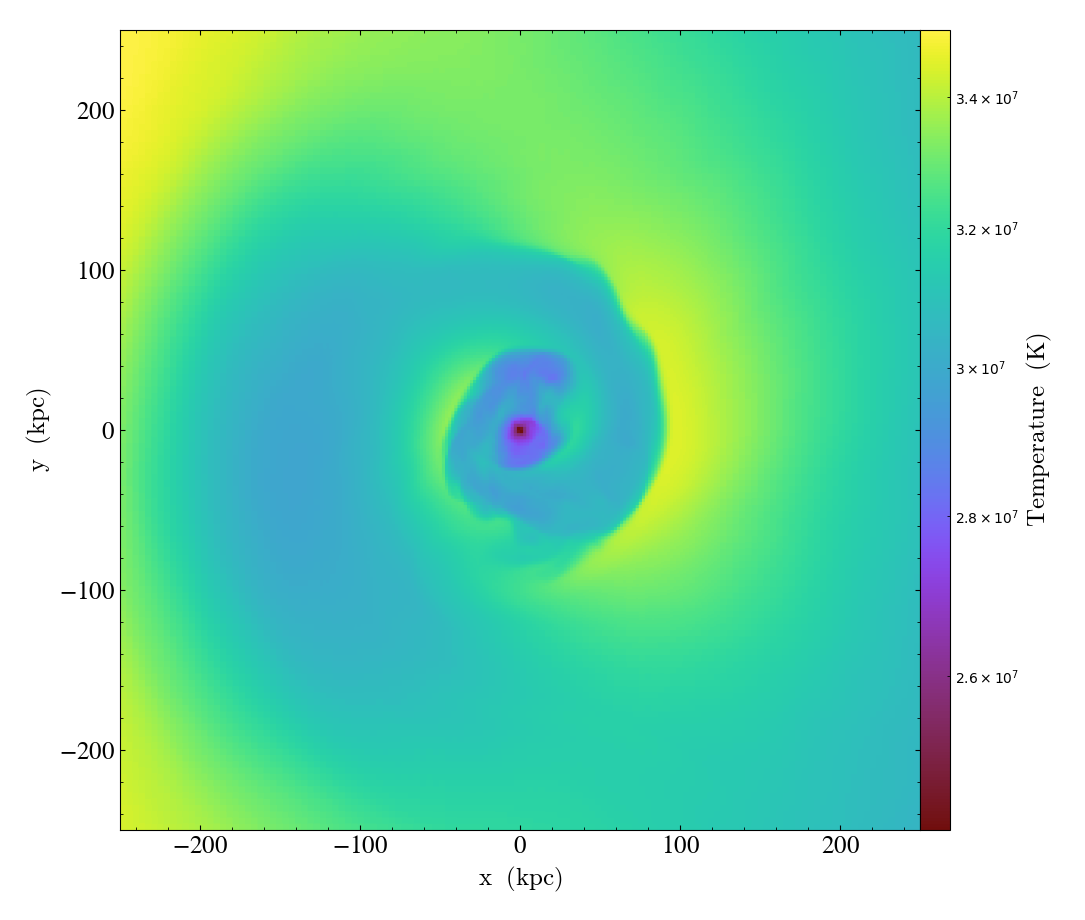

In [18]:
slc2 = yt.SlicePlot(ds2, "z", ("gas", "temperature"), width=(500.0, "kpc"))
slc2.set_log("temperature", True)
slc2.show()

## Creating `FITSImageData` Instances Directly from FRBs, PlotWindow instances, and 3D Grids

If you want more fine-grained control over what goes into the FITS file, you can call `FITSImageData` directly, with various kinds of inputs. For example, you could use a `FixedResolutionBuffer`, and specify you want the units in parsecs instead:

In [19]:
slc3 = ds.slice(0, 0.0)
frb = slc3.to_frb((500.0, "kpc"), 800)
fid_frb = frb.to_fits_data(
    fields=[("gas", "density"), ("gas", "temperature")], length_unit="pc"
)

If one creates a `PlotWindow` instance, e.g. `SlicePlot`, `ProjectionPlot`, etc., you can also call this same method there:

In [20]:
fid_pw = prj.to_fits_data(
    fields=[("gas", "density"), ("gas", "temperature")], length_unit="pc"
)

A 3D FITS cube can also be created from regularly gridded 3D data. In yt, there are covering grids and "arbitrary grids". The easiest way to make an arbitrary grid object is using `ds.r`, where we can index the dataset like a NumPy array, creating a grid of 1.0 Mpc on a side, centered on the origin, with 64 cells on a side:

In [21]:
grid = ds.r[
    (-0.5, "Mpc"):(0.5, "Mpc"):64j,
    (-0.5, "Mpc"):(0.5, "Mpc"):64j,
    (-0.5, "Mpc"):(0.5, "Mpc"):64j,
]
fid_grid = grid.to_fits_data(
    fields=[("gas", "density"), ("gas", "temperature")], length_unit="Mpc"
)

## Other `FITSImageData` Methods

### Creating Images from Others

A `FITSImageData` instance can be generated from one previously written to disk using the `from_file` classmethod:

In [22]:
fid = yt.FITSImageData.from_file("sloshing.fits")
fid.info()

Filename: sloshing.fits
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  TEMPERATURE    1 PrimaryHDU      29   (512, 512)   float64   R


Multiple `FITSImageData` can be combined to create a new one, provided that the coordinate information is the same:

In [23]:
prj_fits2 = yt.FITSProjection(ds, "z", ("gas", "density"), width=(500.0, "kpc"))
prj_fits3 = yt.FITSImageData.from_images([prj_fits, prj_fits2])
prj_fits3.info()

Filename: (No file associated with this FITSImageData)
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  TEMPERATURE    1 PrimaryHDU      29   (512, 512)   float64   R
  1  DENSITY       1 ImageHDU        30   (512, 512)   float64   g/cm**2


Alternatively, individual fields can be popped as well to produce new instances of `FITSImageData`:

In [24]:
dens_fits = prj_fits3.pop("density")

So this new instance would only have the `"density"` field:

In [25]:
dens_fits.info()

Filename: (No file associated with this FITSImageData)
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  DENSITY       1 PrimaryHDU      28   (512, 512)   float64   g/cm**2


and the old one has the `"density"` field removed:

In [26]:
prj_fits3.info()

Filename: (No file associated with this FITSImageData)
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  TEMPERATURE    1 PrimaryHDU      29   (512, 512)   float64   R


### Adding Sky Coordinates to Images

So far, the FITS images we have shown have linear spatial coordinates. We can see this by looking at the header for one of the fields, and examining the `CTYPE1` and `CTYPE2` keywords:

In [27]:
prj_fits["temperature"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
EXTNAME = 'TEMPERATURE'        / extension name                                 
BTYPE   = 'temperature'                                                         
BUNIT   = 'R       '                                                            
LUNIT   =                  1.0 / [kpc]                                          
TUNIT   =                  1.0 / [Myr]                                          
MUNIT   =    100000000000000.0 / [Msun]                                         
VUNIT   =                  1

The `WCSNAME` keyword is set to `"yt"` by default. 

However, one may want to take a projection of an object and make a crude mock observation out of it, with celestial coordinates. For this, we can use the `create_sky_wcs` method. Specify a center (RA, Dec) coordinate in degrees, as well as a linear scale in terms of angle per distance:

In [28]:
sky_center = [30.0, 45.0]  # in degrees
sky_scale = (2.5, "arcsec/kpc")  # could also use a YTQuantity
prj_fits.create_sky_wcs(sky_center, sky_scale, ctype=["RA---TAN", "DEC--TAN"])

By default, a tangent RA/Dec projection is used, but one could also use another projection using the `ctype` keyword. We can now look at the header and see it has the appropriate WCS now. The old `"yt"` WCS has been added to a second WCS in the header, where the parameters have an `"A"` appended to them:

In [29]:
prj_fits["temperature"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
EXTNAME = 'TEMPERATURE'        / extension name                                 
BTYPE   = 'temperature'                                                         
BUNIT   = 'R       '                                                            
LUNIT   =                  1.0 / [kpc]                                          
TUNIT   =                  1.0 / [Myr]                                          
MUNIT   =    100000000000000.0 / [Msun]                                         
VUNIT   =                  1

and now the `WCSNAME` has been set to `"celestial"`. If you want the original WCS to remain in the original place, then you can make the call to `create_sky_wcs` and set `replace_old_wcs=False`, which will put the new, celestial WCS in the second one:

In [30]:
prj_fits3.create_sky_wcs(
    sky_center, sky_scale, ctype=["RA---TAN", "DEC--TAN"], replace_old_wcs=False
)

In [31]:
prj_fits3["temperature"].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
EXTEND  =                    T                                                  
EXTNAME = 'TEMPERATURE'        / extension name                                 
BTYPE   = 'temperature'                                                         
BUNIT   = 'R       '                                                            
LUNIT   =                  1.0 / [kpc]                                          
TUNIT   =                  1.0 / [Myr]                                          
MUNIT   =    100000000000000.0 / [Msun]                                         
VUNIT   =                  1

### Updating Header Parameters

We can also add header keywords to a single field or for all fields in the FITS image using `update_header`:

In [32]:
fid_frb.update_header("all", "time", 0.1)  # Update all the fields
fid_frb.update_header("temperature", "scale", "Rankine")  # Update just one field

In [33]:
print(fid_frb["density"].header["time"])
print(fid_frb["temperature"].header["scale"])

0.1
Rankine


### Changing Image Names

You can use the `change_image_name` method to change the name of an image in a `FITSImageData` instance:

In [34]:
fid_frb.change_image_name("density", "mass_per_volume")
fid_frb.info()  # now "density" should be gone and "mass_per_volume" should be in its place

Filename: (No file associated with this FITSImageData)
No.    Name      Ver    Type      Cards   Dimensions   Format     Units
  0  MASS_PER_VOLUME    1 PrimaryHDU      29   (800, 800)   float64   g/cm**3
  1  TEMPERATURE    1 ImageHDU        31   (800, 800)   float64   K


### Convolving FITS Images

Finally, you can convolve an image inside a `FITSImageData` instance with a kernel, either a Gaussian with a specific standard deviation, or any kernel provided by AstroPy. See AstroPy's [Convolution and filtering](http://docs.astropy.org/en/stable/convolution/index.html) for more details.

In [35]:
dens_fits.writeto("not_convolved.fits", overwrite=True)
# Gaussian kernel with standard deviation of 3.0 kpc
dens_fits.convolve("density", 3.0)
dens_fits.writeto("convolved.fits", overwrite=True)

Now let's load these up as datasets and see the difference:

In [36]:
ds0 = yt.load("not_convolved.fits")
dsc = yt.load("convolved.fits")


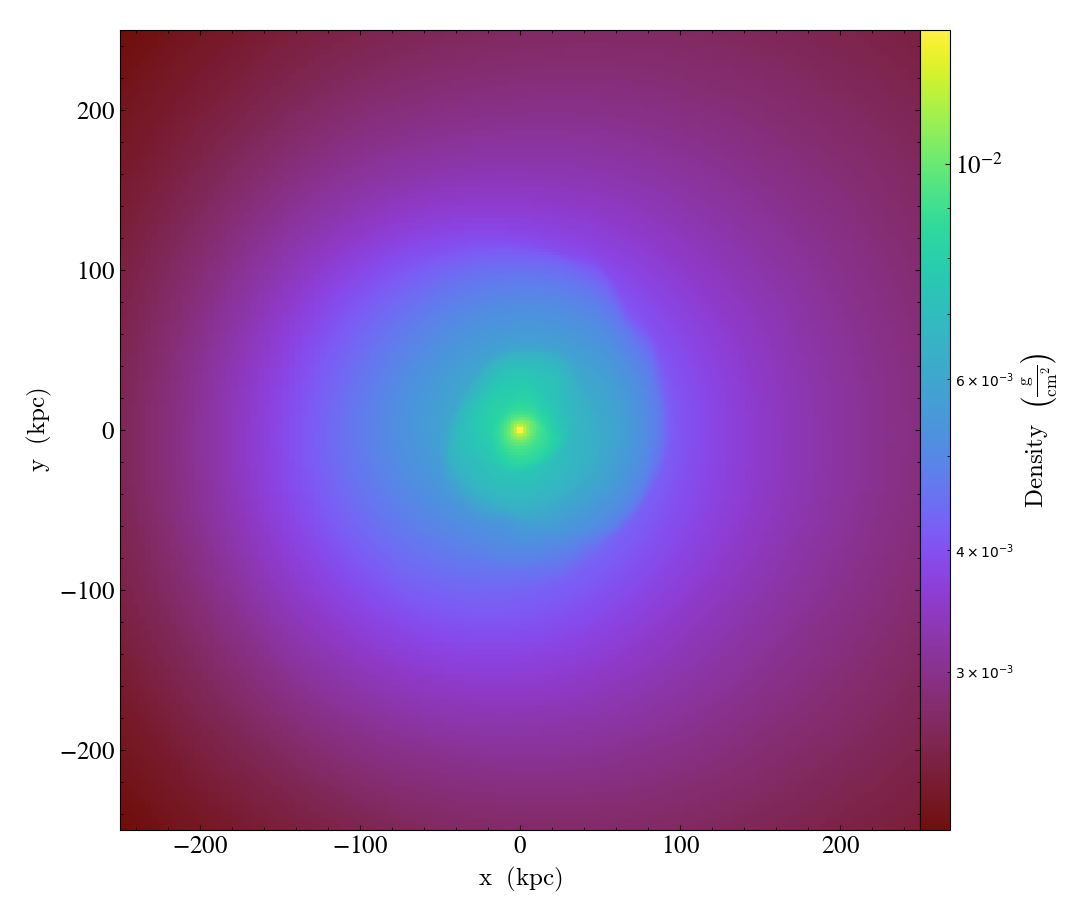

In [37]:
slc3 = yt.SlicePlot(ds0, "z", ("gas", "density"), width=(500.0, "kpc"))
slc3.set_log("density", True)
slc3.show()


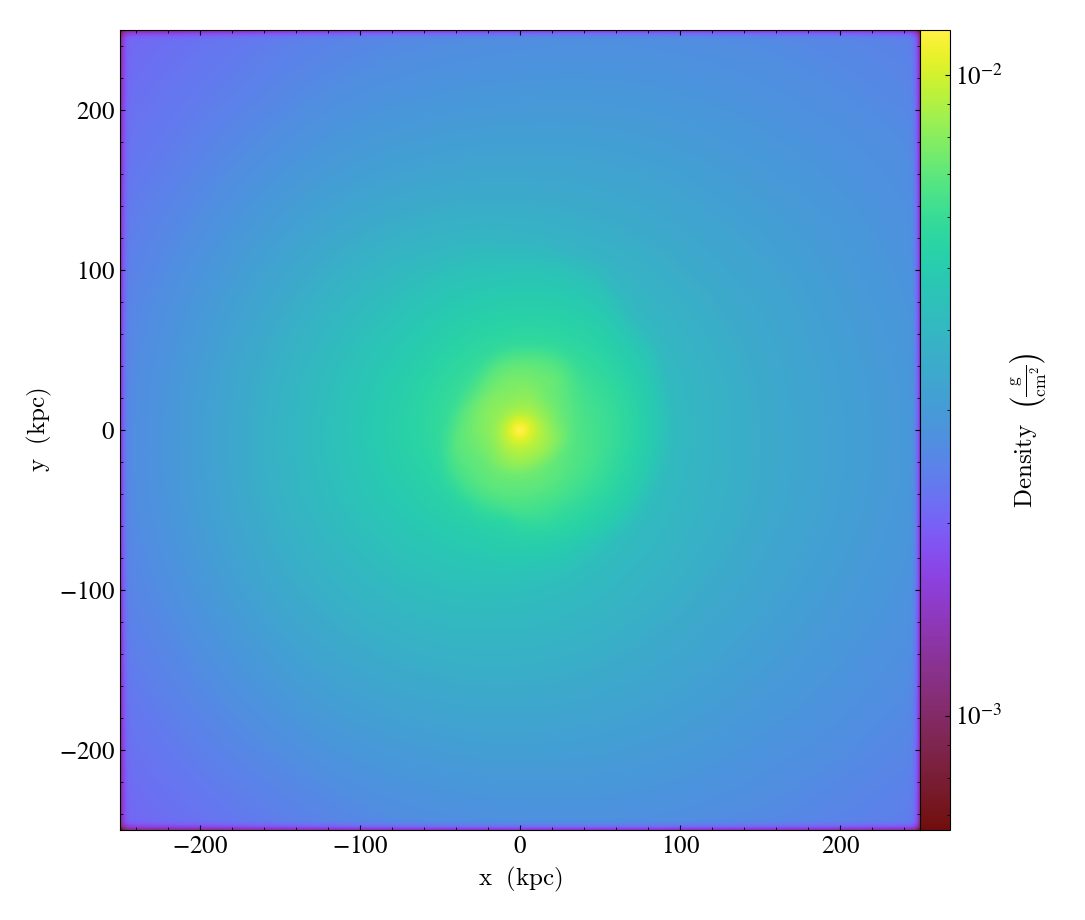

In [38]:
slc4 = yt.SlicePlot(dsc, "z", ("gas", "density"), width=(500.0, "kpc"))
slc4.set_log("density", True)
slc4.show()